Going to train on 50,000,000 molecules from GDB-17

May later try scraping for all molecules w/ positive charge

In [1]:
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns; sns.set()
%matplotlib inline

import keras
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam
import salty
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from random import shuffle
import pandas as pd

/home/wesleybeckner/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
df = pd.read_csv('../../../../../../../GDB17.50000000', names=['smiles'])

only N+ contain positive charges in this dataset

In [4]:
df = df[df['smiles'].str.contains("N+", regex=False)]

In [5]:
values = df['smiles']
print(values.shape)

(76796,)


In [6]:
smile_max_length = values.map(len).max()
print(smile_max_length)

51


We may want to remove cations with more than 25 heavy atoms

(array([1.4000e+01, 8.9000e+01, 1.7810e+03, 7.0240e+03, 1.9826e+04,
        3.7334e+04, 9.1690e+03, 1.4020e+03, 1.1100e+02, 4.6000e+01]),
 array([27. , 29.4, 31.8, 34.2, 36.6, 39. , 41.4, 43.8, 46.2, 48.6, 51. ]),
 <a list of 10 Patch objects>)

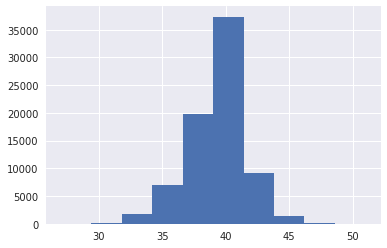

In [7]:
plt.hist(values.map(len))

In [8]:
def pad_smiles(smiles_string, smile_max_length):
     if len(smiles_string) < smile_max_length:
            return smiles_string + " " * (smile_max_length - len(smiles_string))

In [9]:
padded_smiles =  [pad_smiles(i, smile_max_length) for i in values if pad_smiles(i, smile_max_length)]

In [10]:
shuffle(padded_smiles)

In [11]:
def create_char_list(char_set, smile_series):
    for smile in smile_series:
        char_set.update(set(smile))
    return char_set

In [12]:
char_set = set()
char_set = create_char_list(char_set, padded_smiles)

In [13]:
print(len(char_set))
char_set

27


{' ',
 '#',
 '(',
 ')',
 '+',
 '-',
 '1',
 '2',
 '3',
 '4',
 '=',
 'B',
 'C',
 'F',
 'H',
 'I',
 'N',
 'O',
 'S',
 '[',
 ']',
 'c',
 'l',
 'n',
 'o',
 'r',
 's'}

In [14]:
char_list = list(char_set)
chars_in_dict = len(char_list)
char_to_index = dict((c, i) for i, c in enumerate(char_list))
index_to_char = dict((i, c) for i, c in enumerate(char_list))

In [15]:
char_to_index

{' ': 9,
 '#': 22,
 '(': 20,
 ')': 14,
 '+': 8,
 '-': 0,
 '1': 25,
 '2': 19,
 '3': 15,
 '4': 2,
 '=': 11,
 'B': 1,
 'C': 21,
 'F': 6,
 'H': 7,
 'I': 4,
 'N': 18,
 'O': 12,
 'S': 13,
 '[': 23,
 ']': 3,
 'c': 26,
 'l': 16,
 'n': 17,
 'o': 5,
 'r': 24,
 's': 10}

In [16]:
X_train = np.zeros((len(padded_smiles), smile_max_length, chars_in_dict), dtype=np.float32)

In [17]:
X_train.shape

(76792, 51, 27)

In [18]:
for i, smile in enumerate(padded_smiles):
    for j, char in enumerate(smile):
        X_train[i, j, char_to_index[char]] = 1

In [19]:
X_train, X_test = train_test_split(X_train, test_size=0.33, random_state=42)

In [20]:
X_train.shape

(51450, 51, 27)

In [21]:
# need to build RNN to encode. some issues include what the 'embedded dimension' is (vector length of embedded sequence)

so some keras version stuff. 1.0 uses keras.losses to store its loss functions. 2.0 uses objectives. we'll just have to be consistent

In [22]:
from keras import backend as K
from keras.objectives import binary_crossentropy #objs or losses
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers.core import Dense, Activation, Flatten, RepeatVector
from keras.layers.wrappers import TimeDistributed
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Convolution1D

Here I've adapted the exact architecture used in the [paper](https://github.com/maxhodak/keras-molecules/blob/master/molecules/model.py)

In [23]:
def Encoder(x, latent_rep_size, smile_max_length, epsilon_std = 0.01):
    h = Convolution1D(9, 9, activation = 'relu', name='conv_1')(x)
    h = Convolution1D(9, 9, activation = 'relu', name='conv_2')(h)
    h = Convolution1D(10, 11, activation = 'relu', name='conv_3')(h)
    h = Flatten(name = 'flatten_1')(h)
    h = Dense(435, activation = 'relu', name = 'dense_1')(h)

    def sampling(args):
        z_mean_, z_log_var_ = args
        batch_size = K.shape(z_mean_)[0]
        epsilon = K.random_normal(shape=(batch_size, latent_rep_size),
                                  mean=0., stddev = epsilon_std)
        return z_mean_ + K.exp(z_log_var_ / 2) * epsilon

    z_mean = Dense(latent_rep_size, name='z_mean', activation = 'linear')(h)
    z_log_var = Dense(latent_rep_size, name='z_log_var', activation = 'linear')(h)

    def vae_loss(x, x_decoded_mean):
        x = K.flatten(x)
        x_decoded_mean = K.flatten(x_decoded_mean)
        xent_loss = smile_max_length * binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - \
                                 K.exp(z_log_var), axis = -1)
        return xent_loss + kl_loss

    return (vae_loss, Lambda(sampling, output_shape=(latent_rep_size,),
                             name='lambda')([z_mean, z_log_var]))

def Decoder(z, latent_rep_size, smile_max_length, charset_length):
    h = Dense(latent_rep_size, name='latent_input', activation = 'relu')(z)
    h = RepeatVector(smile_max_length, name='repeat_vector')(h)
    h = GRU(501, return_sequences = True, name='gru_1')(h)
    h = GRU(501, return_sequences = True, name='gru_2')(h)
    h = GRU(501, return_sequences = True, name='gru_3')(h)
    return TimeDistributed(Dense(charset_length, activation='softmax'),
                           name='decoded_mean')(h)

In [24]:
x = Input(shape=(smile_max_length, len(char_set)))

In [25]:
_, z = Encoder(x, latent_rep_size=292, smile_max_length=smile_max_length)

In [26]:
encoder = Model(x, z)

encoded_input looks like a dummy layer here:

In [27]:
encoded_input = Input(shape=(292,))

In [28]:
decoder = Model(encoded_input, Decoder(encoded_input, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

create a separate autoencoder model that combines the encoder and decoder (I guess the former cells are for accessing those separate parts of the model)

In [29]:
x1 = Input(shape=(smile_max_length, len(char_set)), name='input_1')

In [30]:
vae_loss, z1 = Encoder(x1, latent_rep_size=292, smile_max_length=smile_max_length)

In [31]:
autoencoder = Model(x1, Decoder(z1, latent_rep_size=292,
                                       smile_max_length=smile_max_length,
                 charset_length=len(char_set)))

we compile and fit

In [32]:
autoencoder.compile(optimizer='Adam', loss=vae_loss, metrics =['accuracy'])

In [33]:
autoencoder.fit(X_train, X_train, shuffle = True, validation_data=(X_test, X_test))

Train on 51450 samples, validate on 25342 samples
Epoch 1/1
51450/51450 [==============================] - 904s 18ms/step - loss: 3.8466 - acc: 0.5281 - val_loss: 2.8455 - val_acc: 0.6573


In [55]:
def sample(a, temperature=1.0):
    # helper function to sample an index from a probability array
#     a = np.log(a) / temperature
#     a = np.exp(a) / np.sum(np.exp(a))
#     return np.argmax(np.random.multinomial(1, a, 1))
    # work around from https://github.com/llSourcell/How-to-Generate-Music-Demo/issues/4
    a = np.log(a) / temperature 
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

In [56]:
values[393977]

'CC12C3C4=C(C1CCC23O)C(=CN4)[N+]([O-])=O'

In [57]:
test_smi = values[393977]
test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1

In [59]:
string = ""
for i in autoencoder.predict(Z):
    for j in i:
        index = sample(j)
        string += index_to_char[index]
print("\n callback guess: " + string)


 callback guess: CC(OCCCCC(1CC==C)OC)(=O))111NN+((O--]==            


In [60]:
properties = ['density', 'cpt', 'viscosity', 'thermal_conductivity',
              'melting_point']
props = properties
devmodel = salty.aggregate_data(props, merge='Union')
devmodel.Data['smiles_string'] = devmodel.Data['smiles-cation']
cations = devmodel.Data['smiles_string'].drop_duplicates()
print(cations.shape)

(276,)


In [61]:
cations = cations.reset_index(drop=True)

In [62]:
test_smi = cations[100]
test_smi = pad_smiles(test_smi, smile_max_length)
Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
for t, char in enumerate(test_smi):
    Z[0, t, char_to_index[char]] = 1
test_smi

'OCCCCCC([n+]1ccn(c1)C)                             '

In [63]:
Z.shape

(1, 51, 27)

In [64]:
string = ""
for i in autoencoder.predict(Z):
    for j in i:
        index = sample(j)
        string += index_to_char[index]
print("\n callback guess: " + string)


 callback guess: CCOC1C=C)C2=CC(NCCC==O))++]([(-]=OO                


Alright. So now I'm going to loop through our 276 cations, sample 100x from the decoder based on these representations, and see how many sanitize with the RDKit

Also will for now remove cations with new elements:

In [65]:
cations_with_proper_chars = []
for smi in cations:
    if set(smi).issubset(char_list):
        cations_with_proper_chars.append(smi)

In [66]:
len(cations_with_proper_chars)

251

so we had to remove 25 cations

In [83]:
cation_samples = []
for smi_index, smi in enumerate(cations_with_proper_chars):
    smi = pad_smiles(smi, smile_max_length)
    Z = np.zeros((1, smile_max_length, len(char_list)), dtype=np.bool)
    for t, char in enumerate(smi):
        Z[0, t, char_to_index[char]] = 1
    string = ""
    for i in autoencoder.predict(Z):
        for j in i:
            index = sample(j, temperature=0.5)
            string += index_to_char[index]
    cation_samples.append(string)

In [84]:
print('sampled cations: {}'.format(len(cation_samples)))
print('unique samples: {}'.format(pd.DataFrame(cation_samples).drop_duplicates().shape[0]))

sampled cations: 251
unique samples: 251


In [85]:
from rdkit import Chem
from rdkit.Chem import Draw

CCCCCCCCNNCCCC=C(NCC11)[N+]([O-])=O                
CCCCC1CCCCCCCC(=CCC1)[N+]([O-])=O                  
CC1CCCCC(CCCCC=NOC1C)[N+]([O-])=O                  


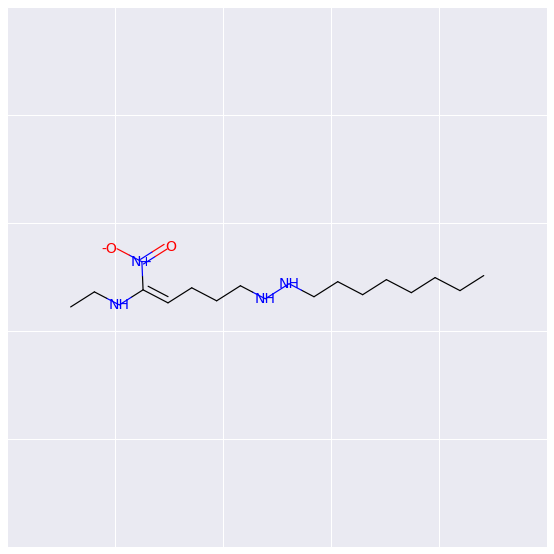

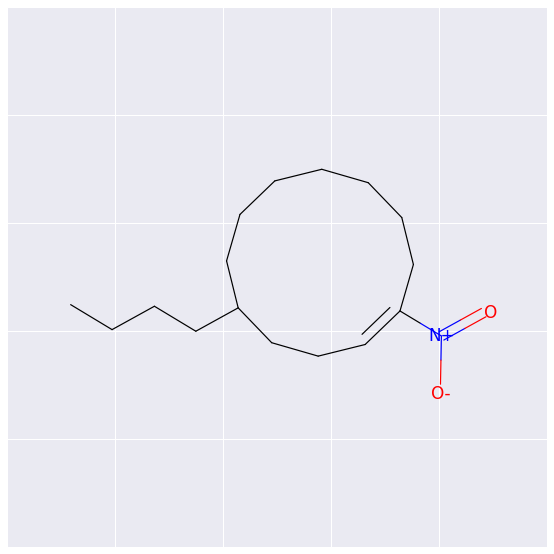

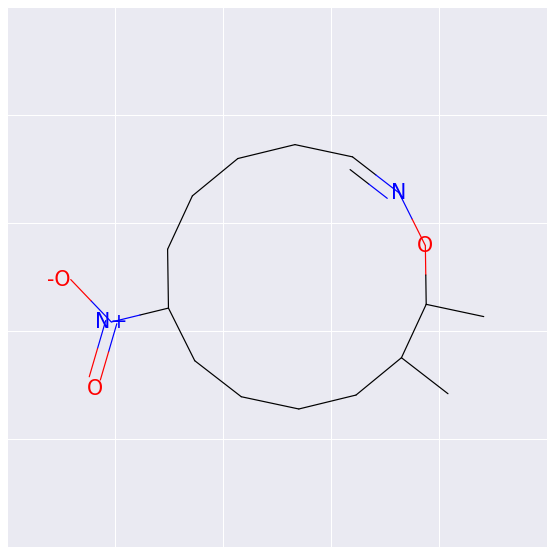

In [86]:
% matplotlib inline
for smi in cation_samples:
    
    try:
        Draw.MolToMPL(Chem.MolFromSmiles(smi))
        print(smi)
    except:
        pass

In [87]:
cation_samples

['CCNCC(CCCO=N)=CCNCC11)[N+]([O-])=O                 ',
 'CC1CCCCCCC=CCNC=2C1N1)N++]([O-])=O                 ',
 'CCC(CCCC=CC1CCNCCC1111[N+]([O-])=OO                ',
 'CCCCCCCCCNC=CNCN=C=C)[N+]([OO])=OO                 ',
 'CCCCCN=CCCCCC=NNC(1C)[N+][[O-])=O                  ',
 'CCNCCNN=CCNCCCCCC=)[N+]([O--)=OO=C                 ',
 'CCCC1CCCSC(CCCC1=N1[NN]([O-])=O))#O                ',
 'CC(CCC=CCNCN==CCCCCC11)N+]([O-)))=O                ',
 'CCCCC1NN)CCCC(CNC=CC)[++]([O-])=O                  ',
 'CCCCCCCCCCNCCCC(CCNO[NN+([O--)==O                  ',
 'CC1CC=CCN=CC=CCNCNCCC)N++([[O]]==O                 ',
 'CCC==NCCCNCCNCCC(CCC1[[++([O--])=O                 ',
 'CCCCCCNC(CCC=C=CC=CC)[N+]([O-])=OO                 ',
 'CCCCCCCC=CCCC=N=CCC1)[N+](OO-])=O                  ',
 'CCNCCCCCN)C=C)CCC(===1)[N+]([O-])=O                ',
 'CCCCCCCCNNCCCC=C(NCC11)[N+]([O-])=O                ',
 'CCNCCC=)(CNCC1CCCC12NN++([O--))=O                  ',
 'CCCCCCNNCCCNC1CONNN=1[N+]([O-])=OO            